In [14]:
from openseespy.opensees import *
import opsvis as opsv
import math
import numpy as np
import matplotlib.pyplot as plt

# Two dimensional Frame: Eigenvalue & Static Loads (Metric Units)

# set some properties
wipe()

model('Basic', '-ndm', 2)

# properties

#    units kN, m

numBay = 3
numFloor = 10
massX = 0.49
M = 0.
coordTransf = "Linear"  # Linear, PDelta, Corotational
massType = "-lMass"  # -lMass, -cMass
# bayWidth = 109.728
h = [49.3896, 49.3896, 47.5488, 47.5488, 47.5488, 47.5488, 47.5488, 47.5488, 47.5488, 47.5488]

bayWidth = 109.728 * 0.3048  # feet to meters (Correct)
storyHeights = [height * 0.3048 for height in h]   # feet to meters (Correct)

E = 29500.0 * 6894757.29  # psi to Pa (N/m^2) (Correct)
g = 9.81   # Acceleration due to gravity (m/s^2) (Correct)
rho_steel = 7850.0   # Density of steel (kg/m^3) (Correct)

beams = ['W24X160', 'W24X160', 'W24X130', 'W24X130', 'W24X110', 'W24X110', 'W24X110', 'W24X110', 'W24X110', 'W24X110']
eColumn = ['W14X246', 'W14X246', 'W14X246', 'W14X211', 'W14X211', 'W14X176', 'W14X176', 'W14X211', 'W14X176', 'W14X176']
iColumn = ['W14X287', 'W14X287', 'W14X287', 'W14X246', 'W14X246', 'W14X211', 'W14X211', 'W14X246', 'W14X211', 'W14X211']
columns = [eColumn, iColumn, iColumn, eColumn]

WSection = {
    'W14X176': [51.7 * 6.4516e-05, 2150. * 4.16231e-07],  # [Area (m^2), I (m^4)] (Correct)
    'W14X211': [62.1 * 6.4516e-05, 2670. * 4.16231e-07],
    'W14X246': [72.3 * 6.4516e-05, 3230. * 4.16231e-07],
    'W14X287': [84.4 * 6.4516e-05, 3910. * 4.16231e-07],
    'W24X110': [32.5 * 6.4516e-05, 3330. * 4.16231e-07],
    'W24X110': [32.5 * 6.4516e-05, 3330. * 4.16231e-07],
    'W24X110': [32.5 * 6.4516e-05, 3330. * 4.16231e-07],
    'W24X130': [38.3 * 6.4516e-05, 4020. * 4.16231e-07],
    'W24X130': [38.3 * 6.4516e-05, 4020. * 4.16231e-07],
    'W24X160': [47.1 * 6.4516e-05, 5120. * 4.16231e-07]
}

nodeTag = 1

# procedure to read
def ElasticBeamColumn(eleTag, iNode, jNode, sectType, E, transfTag, mass_per_length, massType):
    prop = WSection[sectType]
    A = prop[0]  # Area (m^2)
    I = prop[1]  # Moment of Inertia (m^4)

    element('elasticBeamColumn', eleTag, iNode, jNode, A, E, I, transfTag, '-mass', mass_per_length, massType)

# add the nodes
#  - floor at a time
yLoc = 0.
for j in range(0, numFloor + 1):
    xLoc = 0.
    for i in range(0, numBay + 1):
        node(nodeTag, xLoc, yLoc)
        xLoc += bayWidth
        nodeTag += 1

    if j < numFloor:
        storyHeight = storyHeights[j]

    yLoc += storyHeight

# fix first floor
fix(1, 1, 1, 1)
fix(2, 1, 1, 1)
fix(3, 1, 1, 1)
fix(4, 1, 1, 1)

# rigid floor constraint & masses
nodeTagR = 5
nodeTag = 4
for j in range(1, numFloor + 1):
    for i in range(0, numBay + 1):

        if nodeTag != nodeTagR:
            equalDOF(nodeTagR, nodeTag, 1)
        else:
            # mass(nodeTagR, massX, 1.0e-10, 1.0e-10)  # Removed the small mass values
            mass(nodeTagR, massX, massX, 0.0)  # Using massX for both x and y (and 0 for rotation)

        nodeTag += 1

    nodeTagR += numBay + 1

# add the columns
# add column element
geomTransf(coordTransf, 1)
eleTag = 1
for j in range(0, numBay + 1):
    end1 = j + 1
    end2 = end1 + numBay + 1
    thisColumn = columns[j]

    for i in range(0, numFloor):
        secType = thisColumn[i]
        A = WSection[secType][0]
        mass_per_length = rho_steel * A  # Calculate mass per unit length (kg/m)

        ElasticBeamColumn(eleTag, end1, end2, secType, E, 1, mass_per_length, "-lMass")  # Pass the calculated mass
        end1 = end2
        end2 += numBay + 1
        eleTag += 1

# add beam elements
eleTag = eleTag  # Initialize eleTag to the next available tag
for j in range(1, numFloor + 1):
    end1 = (numBay + 1) * j + 1
    for i in range(0, numBay):
        end2 = end1 + 1
        secType = beams[j - 1]
        A = WSection[secType][0]
        mass_per_length = rho_steel * A  # Calculate mass per unit length (kg/m)

        ElasticBeamColumn(eleTag, end1, end2, secType, E, 1, mass_per_length, "-lMass")  # Pass the calculated mass
        end1 = end2
        end1 = end2  # Corrected end1 update
        eleTag += 1

# calculate eigenvalues & print results
numEigen = 7
eigenValues = eigen(numEigen)
PI = 2 * math.asin(1.0)

#
# apply loads for static analysis & perform analysis
#

timeSeries('Linear', 1)
pattern('Plain', 1, 1)

# Corrected Load Application (Based on the image provided)
load(5, 2.5 * 1000, 0., 0.)  
load(9, 5.0 * 1000, 0., 0.)  
load(13, 5.0 * 1000, 0., 0.)
load(17, 7.5 * 1000, 0., 0.)
load(21, 10.0 * 1000, 0., 0.)
load(25, 12.5 * 1000, 0., 0.)
load(29, 15.0 * 1000, 0., 0.)
load(33, 22.5 * 1000, 0., 0.)  
load(37, 25.0 * 1000, 0., 0.)  
load(41, 27.5 * 1000, 0., 0.)  


integrator('LoadControl', 1.0)
algorithm('Linear')
analysis('Static')
analyze(1)

# determine PASS/FAILURE of test
# ok = 0  # Removed the original inadequate test

# Implement a more meaningful check (e.g., check displacement at a node)
node_to_check = 22  # Example: Node at the top of the middle column
disp_x = nodeDisp(node_to_check, 1)  # Get x-displacement

# Define an acceptable displacement threshold (this needs to be determined based on your expectations)
disp_threshold = 0.10  # Example: 100 m (This is an arbitrary value, you need to determine a real threshold)

if abs(disp_x) < disp_threshold:
    print("PASSED: Displacement check at node", node_to_check)
else:
    print("FAILED: Displacement check at node", node_to_check)



PASSED: Displacement check at node 22


<Figure size 1000x1000 with 0 Axes>

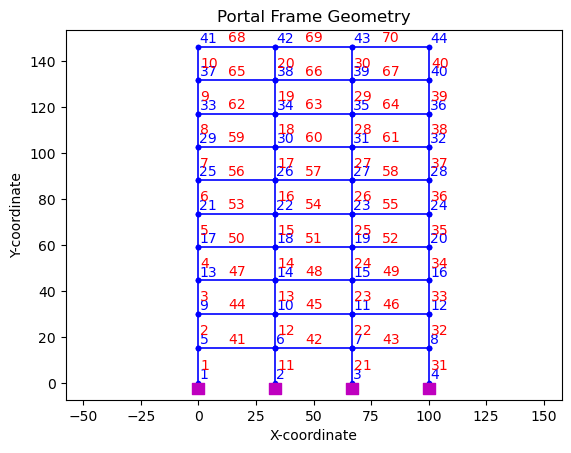

<Figure size 1000x1000 with 0 Axes>

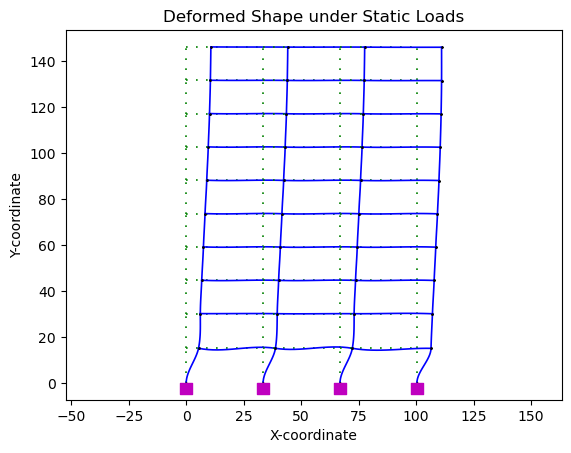

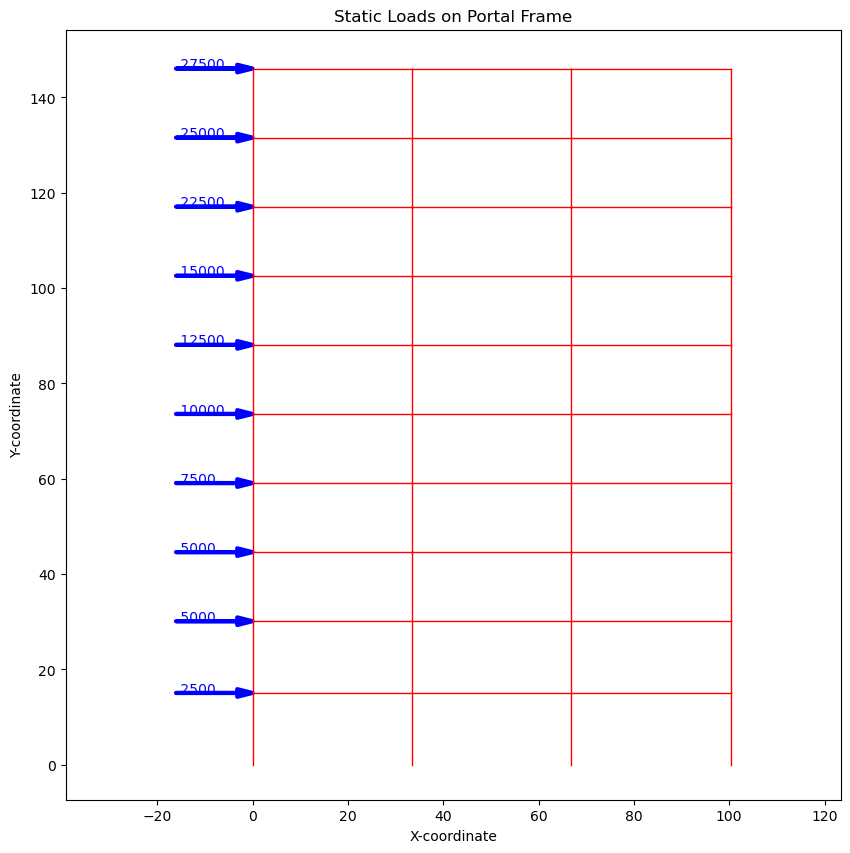

In [15]:
def plotStructure(title):
    plt.figure(figsize=(10, 10))
    opsv.plot_model(node_labels=1, element_labels=1)
    plt.title(title)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    # plt.grid(True)
    plt.savefig('Portal Frame Geometry.png')
    plt.show()

def plotDeformedShape(title, sfac=100):
    plt.figure(figsize=(10, 10))
    opsv.plot_defo(sfac=sfac)
    plt.title(title)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    # plt.grid(True)
    plt.savefig('Deformed Shape under Static Loads.png')
    plt.show()

def plotLoads(title):
    plt.figure(figsize=(10, 10))
    ax_value = plt.gca()
    fmt_model_loads_value = {'color': 'red', 'linewidth': 1} # Example formatting
    opsv.plot_loads_2d(1, False, None, None, fmt_model_loads_value, None, None, ax_value)
    plt.title(title)
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    # plt.grid(True)
    plt.savefig('Static Loads on Portal Frame.png')
    plt.show()

plotStructure('Portal Frame Geometry')
plotDeformedShape('Deformed Shape under Static Loads')
plotLoads('Static Loads on Portal Frame')